In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import torchvision
import torch
import lightning.pytorch as pl

from sklearn.decomposition import PCA
from src.model.full_model import SubCellProtModel,SubCellProtModel_bce
from src.utils.data_handling_utils import initialize_datasets, Retrieval_Data
from src.utils.batch_run_utils import batch_call, get_cell_lines_of_interest, get_isoforms_of_interest, construct_embedding_df
# from src.analysis.pseudo_pca import PseudoPCA
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import time
from enum import Enum
import pdb
import pickle as pk
import math
from src.dataset.dataset import SubCellDatset, DatasetType, CLASSES
from PIL import Image

import sklearn
import sklearn.ensemble
import sklearn.neighbors

fig = plt.figure()

In [2]:
import seaborn as sns

In [3]:
COLLECTION_NAME = "random_splice_isoform_dataset"
MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'



In [4]:
train_dataset, val_dataset, test_dataset, get_data = initialize_datasets(COLLECTION_NAME)
loaded_model = SubCellProtModel().load_from_checkpoint(
    MODEL_CHECKPOINT,
    collection_name=COLLECTION_NAME,
    batch_size=32,
)


In [5]:
#plot GO
from genes_ncbi_human_proteinCoding import GENEID2NT as GeneID2nt_hs
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [6]:
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()

mapper = {}

for key in GeneID2nt_hs:
    mapper[GeneID2nt_hs[key].Symbol] = GeneID2nt_hs[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
ns2assoc = objanno.get_ns2assc()

  EXISTS: go-basic.obo
  EXISTS: gene2go
HMS:0:00:52.355389 345,219 annotations, 20,760 genes, 18,774 GOs, 1 taxids READ: gene2go 


In [7]:
obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms


In [8]:
ns2assoc={'BP':ns2assoc['BP']}
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hs.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, 
        methods = ['fdr_bh']) 
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]



Load BP Ontology Enrichment Analysis ...
 82% 17,010 of 20,651 population items found in association


In [9]:
def go_it_all(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_all)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 0]
    return GO

In [94]:
testCellLines=np.array(['MCF7', 'U251MG', 'GAMG', 'HeLa', 'A549', 'HEK293'])


In [ ]:
from pymongo import MongoClient
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa[COLLECTION_NAME]
    isoform_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$splice_isoform_id", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )

In [ ]:
cell_line_grouping = None
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa[COLLECTION_NAME]
    cell_line_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$cell_line", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )

In [ ]:
cellIDbyCellLine={}
for clidx in cell_line_grouping:
    if clidx['_id'] in testCellLines:
        cellIDbyCellLine[clidx['_id']]=np.array(clidx['ids'])

In [ ]:
savedir_log='log_randomSelection/'
with open(os.path.join(savedir_log,'nucProp_p_cl_thresh'), 'rb') as output:
    nucProp_p_cl_thresh=pk.load(output)


In [ ]:
with open('isoform_grouping_train_alphabetical', 'rb') as output:
    isoform_grouping_train=pk.load(output)

In [ ]:
isoform_grouping_names=np.array([isoform_grouping[pidx]['_id'] for pidx in range(len(isoform_grouping))])

In [64]:
for i in np.unique(isoform_grouping_names):
    print(i)

ABCC5-203
ABI1-201
AC097634.4-201
AC134980.5-201
ACADS-201
ACBD5-221
ACIN1-223
ACTL8-201
ACTRT3-201
ADAMTS3-204
ADARB1-205
ADCYAP1R1-203
ADK-201
ADTRP-201
AKIP1-203
AKIP1-210
AKIRIN1-204
AKT2-234
AMDHD2-219
AMMECR1L-213
AMPD3-202
ANAPC15-202
ANAPC16-205
ANKDD1A-203
ANKRD13D-201
ANKRD27-203
ANKRD63-201
ANKS6-202
ANTXR1-211
AP1B1-202
AP2B1-215
APAF1-202
APBB2-227
ARHGEF28-204
ARL13B-212
ARL6IP4-201
ARL6IP4-206
ARMCX3-201
ARPC1B-213
ASCC3-204
ASMTL-206
ASPA-202
ATF4-201
ATF4-202
ATF4-203
ATF4-204
ATF4-205
ATF4-206
ATF4-207
ATF4-208
ATF4-210
ATG10-203
ATN1-201
ATXN10-212
ATXN7L2-202
B3GALNT1-245
BBX-206
BCL7A-201
BEX1-201
BHLHB9-201
BIN2-210
BLM-212
BLOC1S3-201
BNIP3L-207
BPNT1-206
BUD31-201
C11orf1-204
C11orf49-210
C16orf71-201
C19orf25-204
C1QTNF7-202
C1R-205
C1orf105-201
C1orf174-210
C1orf52-202
C1orf94-202
C21orf91-202
C2orf81-201
C3orf18-202
C4orf3-202
C8orf33-201
C8orf59-205
C9orf40-201
CABYR-206
CACYBP-202
CADPS2-205
CALB2-205
CALML4-206
CAND1-208
CAPZA2-201
CAPZB-202
CASK-229
CASP3

In [ ]:
trainGenes=np.intersect1d(isoform_grouping_names,isoform_grouping_train)
testIdx=np.repeat(True,isoform_grouping_names.size)
for tg in trainGenes:
    testIdx[isoform_grouping_names==tg]=False

In [ ]:
nucProp_p_cl_thresh=nucProp_p_cl_thresh[testIdx]

In [ ]:
ntopP=200

nucProp_p_cl_thresh_var=np.std(nucProp_p_cl_thresh,axis=1)
rankThreshVarPidx=np.argsort(-nucProp_p_cl_thresh_var)

rankThreshVarPidx_unique=np.zeros(ntopP).astype(int)
topIsoformNames_unique=np.repeat('-',ntopP).astype(object)
pCount=0
for pidx in range(len(isoform_grouping)):
    pcurr=isoform_grouping_names[rankThreshVarPidx[pidx]]
    pcurr=pcurr.split('-')[0]
    if pcurr not in topIsoformNames_unique:
        topIsoformNames_unique[pCount]=pcurr
        rankThreshVarPidx_unique[pCount]=rankThreshVarPidx[pidx]
        pCount+=1
    if pCount==ntopP:
        break

In [68]:
topIsoformGO=go_it_all(topIsoformNames_unique)

input genes: 200
mapped genes: 192

Runing BP Ontology Analysis: current study set of 192 IDs.
 91%    174 of    192 study items found in association
100%    192 of    192 study items found in population(20651)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,010 of 20,651 population items
   1,457 terms are associated with    174 of    192 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
      22 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [69]:
topIsoformGO.index=topIsoformGO.GO

In [70]:
topIsoformGO

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes
GO,,,,,,,,,
GO:0045893,GO:0045893,positive regulation of DNA-templated transcrip...,biological_process,4.942763e-07,0.006040,22,192,689,"[FOXO3, HNF1B, NAA15, EGFR, RBBP4, NFE2, RBBP7..."
GO:0048643,GO:0048643,positive regulation of skeletal muscle tissue ...,biological_process,2.694243e-05,0.164618,3,192,7,"[MEF2C, PRKAA1, CTNNB1]"
GO:0000122,GO:0000122,negative regulation of transcription by RNA po...,biological_process,4.101903e-05,0.167084,22,192,912,"[MIER2, FOXO3, MAGEA4, ZBTB7A, NR2C2, ZNF668, ..."
GO:1904179,GO:1904179,positive regulation of adipose tissue development,biological_process,9.048858e-05,0.274829,3,192,10,"[PRKAA1, PPARG, LPL]"
GO:0045944,GO:0045944,positive regulation of transcription by RNA po...,biological_process,1.124505e-04,0.274829,25,192,1185,"[FOXO3, CSRNP1, NR2C2, ZNF668, IKZF3, TCF12, A..."
...,...,...,...,...,...,...,...,...,...
GO:0071356,GO:0071356,cellular response to tumor necrosis factor,biological_process,1.000000e+00,1.000000,1,192,133,[FOXP1]
GO:0007601,GO:0007601,visual perception,biological_process,1.000000e+00,1.000000,1,192,207,[SLC24A1]
GO:0007189,GO:0007189,adenylate cyclase-activating G protein-coupled...,biological_process,1.000000e+00,1.000000,1,192,125,[GPR161]


In [96]:
gene2go={}
for go in topIsoformGO.index:
    for g in topIsoformGO.loc[go].study_genes:
        if g in gene2go.keys():
            gene2go[g].append(go)
        else:
            gene2go[g]=[go]

In [97]:
#plot %genes with the term
k_start=5
k_end=ntopP
nGoPlot=20
colortest=sns.color_palette("husl", nGoPlot)
linestyles=['solid','dotted','dashed','dashdot']

go_genecounts=np.zeros((topIsoformGO.shape[0],k_end-k_start+1))
kidx=0
for k in range(k_start,k_end+1):
    print(k)
    kisoforms=topIsoformNames_unique[:k]
    goIdx=0
    for go in topIsoformGO.index:
        go_genecounts[goIdx,kidx]=np.intersect1d(kisoforms,topIsoformGO.loc[go].study_genes).size/k
        goIdx+=1
    kidx+=1

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


/tmp/ipykernel_1788457/586708660.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


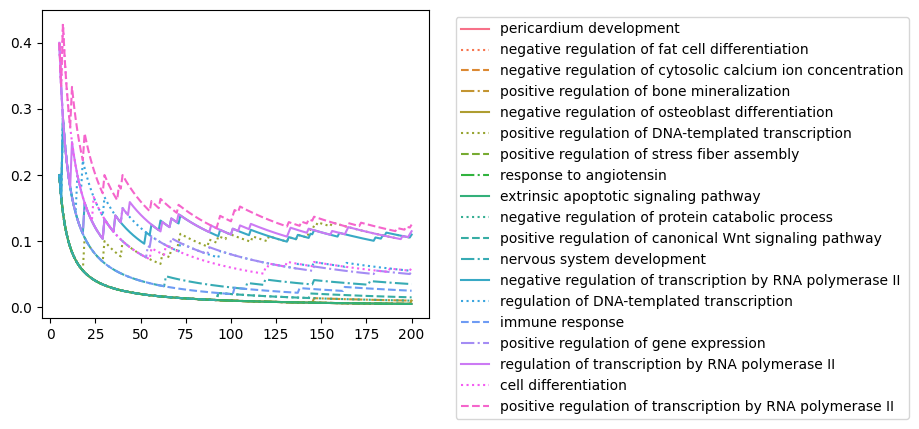

In [74]:
go_geneCounts_rank=np.argsort(np.max(go_genecounts,axis=1))
fig, ax = plt.subplots(figsize=(5, 4))
lines=[]
plotCount=0
xrange=np.arange(k_start,k_end+1)
for gidx_ in range(topIsoformGO.shape[0]):
    gidx=go_geneCounts_rank[gidx_]

    if gidx_>topIsoformGO.shape[0]-nGoPlot:
        c=colortest[plotCount]
        line_i,=ax.plot(xrange,go_genecounts[gidx],color=c,label=topIsoformGO.iloc[gidx].term,linestyle=linestyles[plotCount%len(linestyles)])
        lines.append(line_i)
        plotCount+=1
ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(os.path.join(savedir_log,'topGO_nogray.pdf'))
plt.show()

/tmp/ipykernel_1788457/387505973.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


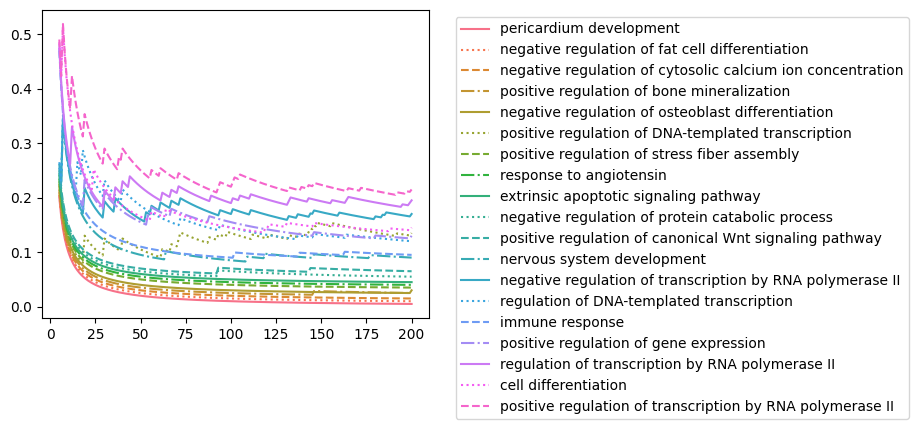

In [100]:
go_geneCounts_rank=np.argsort(np.max(go_genecounts,axis=1))
fig, ax = plt.subplots(figsize=(5, 4))
lines=[]
plotCount=0
xrange=np.arange(k_start,k_end+1)
for gidx_ in range(topIsoformGO.shape[0]):
    gidx=go_geneCounts_rank[gidx_]

    if gidx_>topIsoformGO.shape[0]-nGoPlot:
        c=colortest[plotCount]
        line_i,=ax.plot(xrange,go_genecounts[gidx]+0.005*plotCount,color=c,label=topIsoformGO.iloc[gidx].term,linestyle=linestyles[plotCount%len(linestyles)])
        lines.append(line_i)
        plotCount+=1
ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(os.path.join(savedir_log,'topGO_nogray_jitter.pdf'))
plt.show()

In [45]:
#plot genes that introduce new GO terms
coveredGOterms=[]
uniqueGObyK=np.zeros(ntopP)
for k in range(ntopP):
    pcurr=topIsoformNames_unique[k]
    if pcurr in gene2go.keys():
        print(pcurr)
        for g in gene2go[pcurr]:
            if g not in coveredGOterms:
                print(topIsoformGO.loc[g].term)
        print('\n')
        coveredGOterms=np.unique(np.concatenate((coveredGOterms,gene2go[pcurr])))
        
            
    uniqueGObyK[k]=coveredGOterms.size


SMAD3
positive regulation of DNA-templated transcription
negative regulation of transcription by RNA polymerase II
positive regulation of transcription by RNA polymerase II
negative regulation of cardiac muscle hypertrophy in response to stress
positive regulation of miRNA transcription
cellular response to transforming growth factor beta stimulus
embryonic foregut morphogenesis
positive regulation of gene expression
response to hypoxia
negative regulation of gene expression
regulation of miRNA transcription
negative regulation of lung blood pressure
positive regulation of transforming growth factor beta3 production
positive regulation of epithelial to mesenchymal transition
cell differentiation
negative regulation of apoptotic process
regulation of DNA-templated transcription
positive regulation of interleukin-1 beta production
paraxial mesoderm morphogenesis
heart looping
activation of cysteine-type endopeptidase activity involved in apoptotic process
regulation of transcription by R

In [80]:
with open(os.path.join(savedir_log,'currTopPairs_errorSub_testonly'), 'rb') as output:
    currTopPairs=pk.load(output)
with open(os.path.join(savedir_log,'currTopPairs_true_errorSub_testonly'), 'rb') as output:
    currTopPairs_true=pk.load(output)

In [81]:
currTopPairs_overlap=[]
for p in currTopPairs:
    if p in currTopPairs_true:
        currTopPairs_overlap.append(p)

In [26]:
len(currTopPairs_overlap)

11

In [27]:
currTopPairs_overlap

['ING3',
 'IKZF3',
 'DSN1',
 'THYN1',
 'MED17',
 'TSEN2',
 'CYP20A1',
 'HPDL',
 'PRPF40A',
 'N4BP2',
 'GLRX2']

In [48]:
topIsoformGO_sc=go_it_all(currTopPairs_overlap)

input genes: 11
mapped genes: 11

Runing BP Ontology Analysis: current study set of 11 IDs.
 82%      9 of     11 study items found in association
100%     11 of     11 study items found in population(20651)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,010 of 20,651 population items
      49 terms are associated with      9 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [49]:
topIsoformGO_sc.index=topIsoformGO_sc.GO

In [103]:
gene2go_sc={}
for go in topIsoformGO_sc.index:
    for g in topIsoformGO_sc.loc[go].study_genes:
        if g in gene2go_sc.keys():
            gene2go_sc[g].append(go)
        else:
            gene2go_sc[g]=[go]

In [104]:
#plot %genes with the term
k_start=5
k_end=len(currTopPairs_overlap)

linestyles=['solid','dotted','dashed','dashdot']

go_genecounts_sc=np.zeros((topIsoformGO_sc.shape[0],k_end-k_start+1))
kidx=0
for k in range(k_start,k_end+1):
    print(k)
    kisoforms=currTopPairs_overlap[:k]
    goIdx=0
    for go in topIsoformGO_sc.index:
        go_genecounts_sc[goIdx,kidx]=np.intersect1d(kisoforms,topIsoformGO_sc.loc[go].study_genes).size/k
        goIdx+=1
    kidx+=1

5
6
7
8
9
10
11


/tmp/ipykernel_1788457/167172650.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


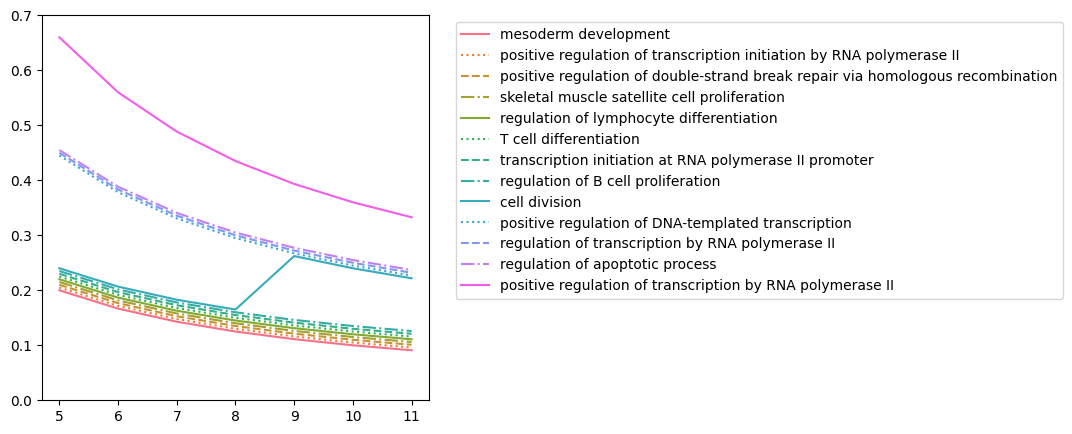

In [92]:
nGoPlot=14
colortest=sns.color_palette("husl", nGoPlot)

go_geneCounts_rank_sc=np.argsort(np.max(go_genecounts_sc,axis=1))
fig, ax = plt.subplots(figsize=(5, 5))
lines=[]
plotCount=0
xrange=np.arange(k_start,k_end+1)
for gidx_ in range(topIsoformGO_sc.shape[0]):
    gidx=go_geneCounts_rank_sc[gidx_]

    if gidx_>topIsoformGO_sc.shape[0]-nGoPlot:
        c=colortest[plotCount]
        line_i,=ax.plot(xrange,go_genecounts_sc[gidx]+0.005*plotCount,color=c,label=topIsoformGO_sc.iloc[gidx].term,linestyle=linestyles[plotCount%len(linestyles)])
        lines.append(line_i)
        plotCount+=1
plt.ylim(0,0.7)
ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(os.path.join(savedir_log,'topGO_sc_jitter.pdf'))
plt.show()

/tmp/ipykernel_1788457/1689052290.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


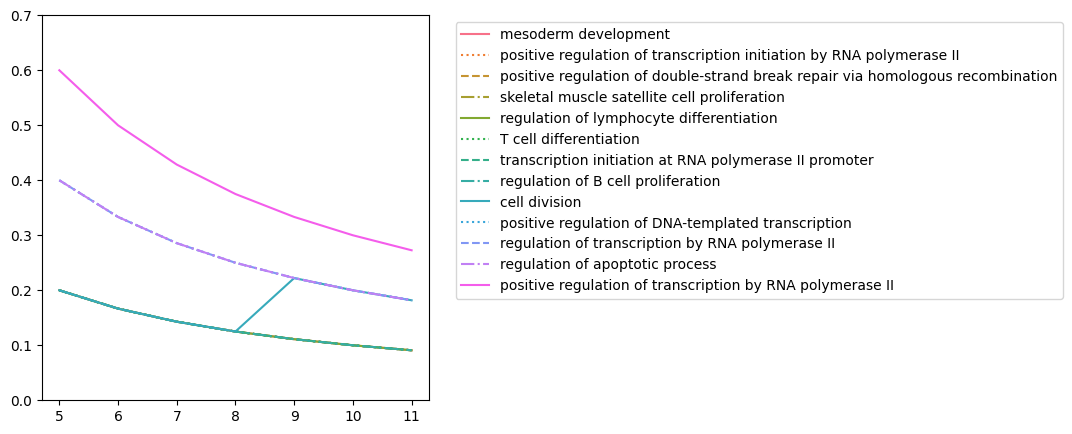

In [105]:
nGoPlot=14
colortest=sns.color_palette("husl", nGoPlot)

go_geneCounts_rank_sc=np.argsort(np.max(go_genecounts_sc,axis=1))
fig, ax = plt.subplots(figsize=(5, 5))
lines=[]
plotCount=0
xrange=np.arange(k_start,k_end+1)
for gidx_ in range(topIsoformGO_sc.shape[0]):
    gidx=go_geneCounts_rank_sc[gidx_]

    if gidx_>topIsoformGO_sc.shape[0]-nGoPlot:
        c=colortest[plotCount]
        line_i,=ax.plot(xrange,go_genecounts_sc[gidx],color=c,label=topIsoformGO_sc.iloc[gidx].term,linestyle=linestyles[plotCount%len(linestyles)])
        lines.append(line_i)
        plotCount+=1
plt.ylim(0,0.7)
ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(os.path.join(savedir_log,'topGO_sc_nogray.pdf'))
plt.show()

In [35]:
#plot genes that introduce new GO terms
coveredGOterms_sc=np.array([])
uniqueGObyK_sc=np.zeros(len(currTopPairs_overlap))
for k in range(len(currTopPairs_overlap)):
    pcurr=currTopPairs_overlap[k]
    if pcurr in gene2go_sc.keys():
        print(pcurr)
        for g in gene2go_sc[pcurr]:
            if g not in coveredGOterms_sc:
                print(topIsoformGO_sc.loc[g].term)
        print('\n')
        coveredGOterms_sc=np.unique(np.concatenate((coveredGOterms_sc,gene2go_sc[pcurr])))
        
            
    uniqueGObyK_sc[k]=coveredGOterms_sc.size


ING3
regulation of apoptotic process
regulation of double-strand break repair
positive regulation of double-strand break repair via homologous recombination
positive regulation of transcription by RNA polymerase II
regulation of DNA-templated transcription
positive regulation of DNA-templated transcription
regulation of cell cycle
chromatin remodeling


IKZF3
regulation of lymphocyte differentiation
regulation of B cell proliferation
regulation of B cell differentiation
mesoderm development
T cell differentiation
response to bacterium
B cell differentiation
regulation of transcription by RNA polymerase II


DSN1
skeletal muscle satellite cell proliferation
attachment of spindle microtubules to kinetochore
cell division


MED17
transcription initiation at RNA polymerase II promoter
positive regulation of transcription elongation by RNA polymerase II
somatic stem cell population maintenance
positive regulation of transcription initiation by RNA polymerase II
RNA polymerase II preinitiati

/tmp/ipykernel_1788457/970873738.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if g not in coveredGOterms_sc:
